# Error Drivers with Shaps

This notebook leverages SHAP values to identify the charactersitics of the features that are driving the error in the model (or driving the good performance of the model).


In [99]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.core.config_loader import ConfigLoader
from src.core.clients.bigquery import BigQueryClient
import pandas as pd
%matplotlib inline

bq_client = BigQueryClient()
config_loader = ConfigLoader()

INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines


In [100]:
from src.core.models.xgboost import XgboostModel

model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260130_181258_bestsofar/model_0.pickle'
)
type(model)

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260130_181258_bestsofar/model_0.pickle


src.core.models.xgboost.XgboostModel

In [101]:
# Generate predictions

df = model.training_df.copy()
df["actuals"] = df[config_loader.target_col]
df['predictions'] = model.predict(df[model.features], False)
df['percent_error'] = abs(df['predictions'] - df["actuals"])/df["actuals"]
df['error'] = abs(df['predictions'] - df["actuals"])
df['bench_percent_error'] = abs(df[config_loader.benchmark_col] - df["actuals"])/df["actuals"]
df['bench_error'] = abs(df[config_loader.benchmark_col] - df["actuals"])
df['beat_benchmark_percent'] = df['percent_error'] - df['bench_percent_error']
df['beat_benchmark'] = df['error'] - df['bench_error']


In [102]:
import xgboost as xgb

def get_shaps(df):
    df = df.copy()

    # Shap table for validation:
    shaps_dataset = df[model.features]
    matrix_observation = xgb.DMatrix(shaps_dataset)

    # Assuming your model is named 'model' and your features are in 'X_train'
    shap_values = model.model.get_booster().predict(matrix_observation, pred_contribs=True)

    # 1. SHAP values DataFrame (excluding bias)
    shap_df = pd.DataFrame(shap_values[:, :-1], columns=model.features, index=shaps_dataset.index)

    # 2. Merge predictions
    shaps_with_preds = shap_df.merge(df[['error', 'predictions', 'beat_benchmark']], left_index = True, right_index = True)

    return shaps_with_preds


In [103]:
get_shaps(df)

,fea_item_monthly_sales_roll_count_12_months,fea_item_monthly_sales_lag_1_months,fea_item_monthly_sales_lag_2_months,fea_item_monthly_sales_lag_3_months,fea_item_monthly_sales_lag_4_months,fea_item_monthly_sales_lag_5_months,fea_item_monthly_sales_lag_6_months,fea_item_monthly_sales_lag_7_months,fea_item_monthly_sales_lag_8_months,fea_item_monthly_sales_lag_9_months,...,feature_avg_sales_not_religious_event,fea_item_monthly_sales_roll_min_12_months,fea_item_monthly_sales_1,feature_avg_sales_religious_event_1,feature_ratio_avg_sales_cultural_event_roll_avg_6_months,feature_avg_sales_sport_event,feature_not_gift_driven_avg_sales,error,predictions,beat_benchmark
0,0.000122,0.026306,0.007024,-0.000210,0.017291,-0.000023,0.011544,0.001380,0.001342,0.000679,...,0.005124,-0.003815,0.0,0.0,0.008835,0.003718,0.079377,0.292965,5.970434,0.15425
1,0.000332,0.042285,-0.000358,-0.000170,0.002773,-0.000442,0.006879,0.000096,-0.000245,-0.002099,...,0.007455,-0.007818,0.0,0.0,-0.003206,0.005919,-0.039099,0.363478,5.083260,0.098524
2,0.000286,0.049664,0.000506,0.000899,0.002551,0.002176,0.014806,0.000021,0.010730,0.003603,...,0.009034,-0.000461,0.0,0.0,-0.000584,0.007579,0.103862,0.010441,6.452981,-0.215247
4,0.000199,0.004007,0.000136,0.000224,0.003827,0.000896,0.005504,0.000251,0.001646,-0.004463,...,0.003522,-0.000331,0.0,0.0,-0.000569,0.000625,-0.014886,0.047102,4.337562,-0.139775
5,0.000147,0.033584,0.001662,-0.000202,0.003713,0.000122,0.022713,0.003505,0.001050,-0.002705,...,0.002923,-0.004449,0.0,0.0,0.008626,0.009579,-0.003618,0.492656,5.284997,-0.022306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92268,-0.000040,-0.052572,0.000288,0.000529,-0.001400,0.000097,-0.003914,-0.000937,-0.005980,-0.003748,...,-0.018035,0.003521,0.0,0.0,0.005024,-0.000373,-0.022292,0.037455,3.258382,-0.485793
92269,-0.000039,-0.014539,0.000142,0.000310,-0.000417,-0.000881,-0.003068,-0.001745,-0.003039,-0.001978,...,0.003359,-0.000488,0.0,0.0,0.000289,-0.000333,-0.023589,0.332088,3.995649,0.044406
92270,-0.000022,0.004092,-0.000094,-0.000826,-0.000021,0.000380,-0.010235,-0.001115,0.000749,-0.000684,...,0.003976,-0.000404,0.0,0.0,-0.005861,-0.000629,-0.032597,0.034236,4.697675,-0.279059
92271,-0.000162,-0.070543,0.000295,0.000594,-0.006226,0.000232,-0.005367,-0.003812,0.003132,0.000848,...,-0.019913,-0.002264,0.0,0.0,0.002799,-0.001153,-0.034078,0.140598,4.049057,-0.958014


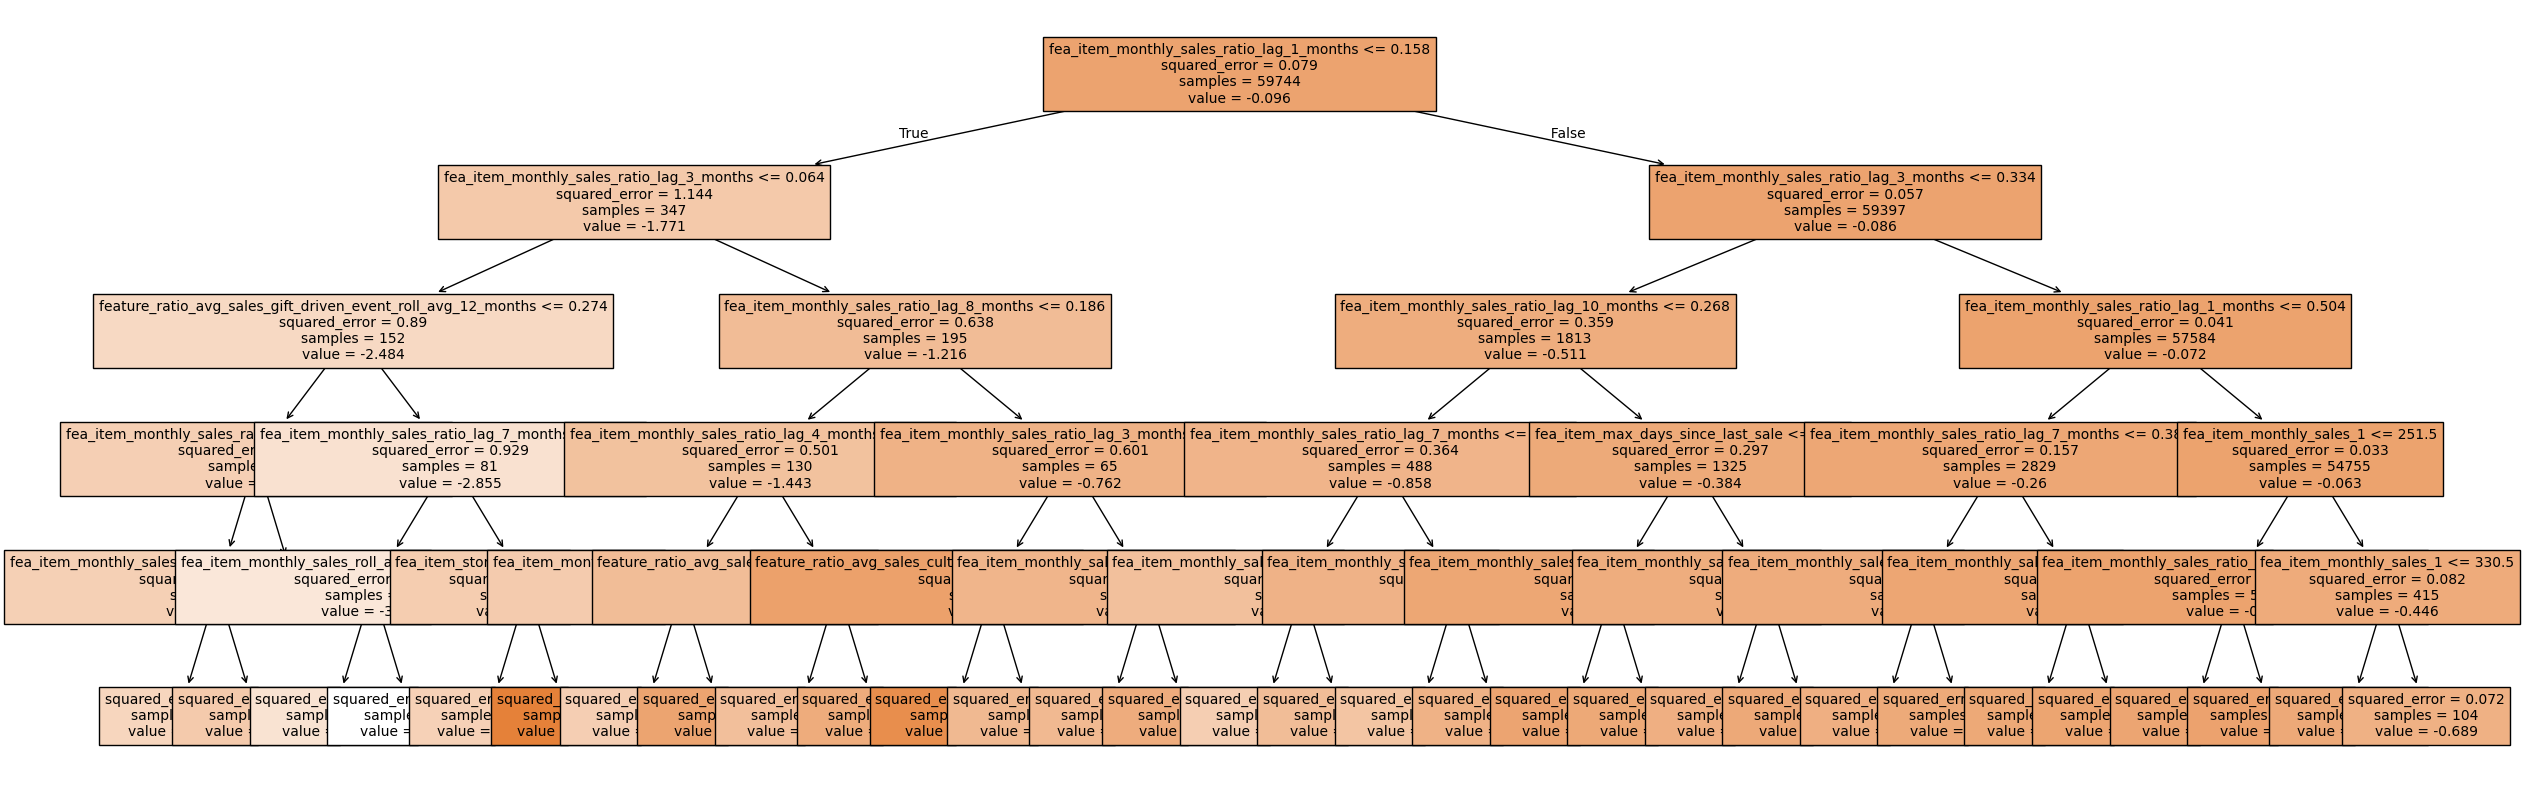

In [104]:
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
import matplotlib.pyplot as plt

%matplotlib inline

regressor = DecisionTreeRegressor(max_depth = 5)
regressor.fit(df[model.features], df['beat_benchmark'])

tree_rules = export_text(regressor, feature_names = list(model.features), show_weights = True)

plt.figure(figsize=(30, 10))
plot_tree(regressor, feature_names = model.features, filled=True, fontsize=10)
plt.show()


In [105]:
import pandas as pd

tree = regressor.tree_
tree_df = pd.DataFrame({
    "feature": [model.features[i] if i != -2 else "leaf" for i in tree.feature],
    "threshold": tree.threshold,
    "value": tree.value.flatten(),
    "n_node_samples": tree.n_node_samples,
    "impurity": tree.impurity,
    "left_child": tree.children_left,
    "right_child": tree.children_right
})
tree_df.to_csv("tree_structure.csv", index=False)

In [106]:
tree_df.head()

,feature,threshold,value,n_node_samples,impurity,left_child,right_child
0,fea_item_monthly_sales_ratio_lag_1_months,0.158114,-0.095589,59744,0.079240,1,30
1,fea_item_monthly_sales_ratio_lag_3_months,0.064309,-1.771258,347,1.144129,2,15
2,feature_ratio_avg_sales_gift_driven_event_roll...,0.273621,-2.483973,152,0.890128,3,8
3,fea_item_monthly_sales_ratio_lag_7_months,0.333333,-2.060555,71,0.509228,4,7
4,fea_item_monthly_sales_roll_coeffvar_12_months,1.477353,-2.097805,70,0.417990,5,6


In [107]:
# Get it in the form of a feature importance:
df_feature_importance = pd.DataFrame(regressor.feature_importances_, columns=["importance"])
df_feature_importance["features"] = regressor.feature_names_in_
display(df_feature_importance.sort_values(["importance"], ascending = False).head(20))

,importance,features
47,0.535702,fea_item_monthly_sales_ratio_lag_1_months
51,0.238011,fea_item_monthly_sales_ratio_lag_3_months
75,0.054036,fea_item_monthly_sales_ratio_lag_7_months
56,0.043391,fea_item_monthly_sales_ratio_lag_10_months
104,0.034354,fea_item_monthly_sales_1
40,0.015514,fea_item_monthly_sales_ratio_lag_4_months
52,0.013908,fea_item_max_days_since_last_sale
59,0.011972,fea_item_monthly_sales_ratio_lag_8_months
21,0.011794,feature_ratio_avg_sales_gift_driven_event_roll...
55,0.010666,fea_item_monthly_sales_ratio_lag_9_months


# 02. Analyze Feature and its contribution

In [108]:

sales_query = f"""
    SELECT 
    ctx_item_id,
    ctx_date_month,
    ctx_cat_id,
    ctx_dept_id,
    ctx_store_id,
    feature_avg_sales_religious_event,
    feature_ratio_avg_sales_religious_event,
    feature_ratio_avg_sales_religious_event_roll_avg_12_months,
    FROM `porygon-pipelines.walmart_training_tables.walmart_master_table` tgt
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND is_stockout_tgt = 0
        AND fea_item_longevity_months >=3
        AND is_stockout_prev_3_m = 0
"""


# Extract data
df_extracted = bq_client.load_from_query(sales_query)

/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 92273 rows from custom query.


In [109]:
feature_name = 'fea_item_monthly_sales_ratio_lag_1_months'
other_features = []
df_feature = df[[feature_name, 'beat_benchmark','error', 'ctx_date_month', "ctx_item_id"]+ other_features].rename(columns = {feature_name:f"shap_{feature_name}"})
df_exploration = df_feature.merge(model.training_df[[feature_name]], left_index = True, right_index = True)

# Create quantiles of shaps
df_exploration['shap_quantiles'] = pd.qcut(df_exploration[f"shap_{feature_name}"], q = 5)
df_exploration[f"isna_{feature_name}"] = df_exploration[feature_name].isna()

# join extracted features
df_exploration_merged = df_exploration.merge(df_extracted, on = ["ctx_item_id", "ctx_date_month"])
df_exploration_merged[f"isna_feature_avg_sales_religious_event"] = df_exploration_merged['feature_avg_sales_religious_event'].isna()

In [110]:
df_exploration_merged.groupby(['shap_quantiles'])[[
    feature_name, 'error', 'beat_benchmark'
]+ other_features].mean()

/var/folders/mq/1yp0hqvn7mg6cbdtcfjwn9fm0000gn/T/ipykernel_69722/912135113.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_exploration_merged.groupby(['shap_quantiles'])[[


,fea_item_monthly_sales_ratio_lag_1_months,error,beat_benchmark
shap_quantiles,,,
"(-0.001, 0.723]",0.538954,0.258684,-0.231174
"(0.723, 0.909]",0.821789,0.212495,-0.044606
"(0.909, 1.085]",0.995842,0.203471,-0.046414
"(1.085, 1.364]",1.209171,0.205606,-0.05566
"(1.364, 106.5]",2.184815,0.243516,-0.098843


In [111]:
df_exploration_merged['ctx_month'] = pd.to_datetime(df_exploration_merged['ctx_date_month']).dt.month
df_exploration_merged.groupby(['ctx_month',])[['error']].mean()

,error
ctx_month,
1,0.215468
2,0.216469
3,0.216053
4,0.219569
5,0.228401
6,0.221743
7,0.21776
8,0.2301
9,0.237759


# Conclussion

I have discovered that the error is largely driven by the model not capturing events that are sensitive to religous events such as Christmas. I will iterate by adding religious event indicators to the model.
